Using selenium to scrape data from the web page

In [1]:
!pip install selenium
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
from selenium import webdriver
import pandas as pd
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

     |████████████████████████████████| 911kB 2.7MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 28 not upgraded.
Need to get 70.8 MB of archives.
After this operation, 254 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 77.0.3865.90-0ubuntu0.18.04.1 [1,079 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 77.0.3865.90-0ubuntu0.18.04.1 [62.3 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe

In [0]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

Accessing the edmunds forum over 99 pages and finding date, userid and comments fields from it. This data is then added to a dataframe named comments.

In [0]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
comments = pd.DataFrame(columns = ['Date','user_id','comments']) 
for i in range(1,101):
   url='https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'+str(i)
   driver.get(url)
   
   ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
   comment_ids = []
   for i in ids:
      comment_ids.append(i.get_attribute('id'))

   for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
      comment = user_message.text
                                    
      #Adding date, userid and comment for each user in a dataframe    
      comments.loc[len(comments)] = [date,userid,comment]


In [8]:
comments.head()

,Date,user_id,comments
0,"March 25, 2002 5:54AM",merc1,I personally think that with a few tweaks the ...
1,"March 25, 2002 7:06AM",fredvh,I am debating a new purchase and these two are...
2,"March 25, 2002 5:02PM",blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,"March 25, 2002 11:04PM",hungrywhale,And no manual tranny. That may not matter to y...
4,"March 26, 2002 12:44AM",riez,One beauty of BMW 3 Series is that there are s...


Preprocess function defined to remove stopwords and punctuation in comments column

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

def preprocess(sentence):
	sentence = sentence.lower()
	tokenizer = RegexpTokenizer(r'\w+')
	tokens = tokenizer.tokenize(sentence)
	filtered_words = [w for w in tokens if not w in stopwords.words('english')]
	return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Creating a new column named filtered comments after removing punctuation and stopwords

In [0]:
comments['filtered comments']=comments['comments'].map(preprocess)

In [11]:
comments.head()

,Date,user_id,comments,filtered comments
0,"March 25, 2002 5:54AM",merc1,I personally think that with a few tweaks the ...,personally think tweaks c320 could also sit to...
1,"March 25, 2002 7:06AM",fredvh,I am debating a new purchase and these two are...,debating new purchase two top list price diffe...
2,"March 25, 2002 5:02PM",blueguydotcom,"Great handling, RWD, excellent engine and the ...",great handling rwd excellent engine best warra...
3,"March 25, 2002 11:04PM",hungrywhale,And no manual tranny. That may not matter to y...,manual tranny may matter certainly matter many...
4,"March 26, 2002 12:44AM",riez,One beauty of BMW 3 Series is that there are s...,one beauty bmw 3 series many models choose alm...


Copying the data to a csv file for easy access

In [0]:
comments.to_csv('comments.csv')

In order to simplify analysis, we will replace model names with their equivalent brand names. In order to do this, we will find the frequency distribution of words across all posts. This is then saved to wordcount.csv for easy access.

In [14]:
nltk.download('punkt')
text = comments['filtered comments'].str.lower().str.cat(sep=' ')
allWords = nltk.tokenize.word_tokenize(text)
allWordsDist=nltk.FreqDist(allWords)
text_df = pd.DataFrame.from_dict(allWordsDist, orient='index')
text_df.columns = ['Frequency']
text_df.index.name = 'Word'


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
text_df.to_csv('wordcount.csv')

Now we have 3 key datasets:
1. Wordcount: This has every word across user_posts with the frequency
2. Models: This has the mapping between every brand name to its different models
3. Comments: This has the date, user id, comments and a new column named filtered comments created after removing stopwords and punctuation

In [16]:
#Mounting google drive to access the csv files created
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
comments=pd.read_csv('/content/drive/My Drive/Text Analytics Project/comments.csv')
models=pd.read_csv('https://raw.githubusercontent.com/chenson2018/Text-Analysis-Class/master/Assignment%201/models%20(5)-Satya.csv', header=None)
wordcount=pd.read_csv('/content/drive/My Drive/Text Analytics Project/wordcount.csv')

In [59]:
models.rename(columns={0:'brand',1:'model'},inplace=True)
models.head()

,brand,model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx


In [60]:
comments.head()

,Unnamed: 0,Date,user_id,comments,filtered comments
0,0,"March 25, 2002 5:54AM",merc1,I personally think that with a few tweaks the ...,personally think tweaks c320 could also sit to...
1,1,"March 25, 2002 7:06AM",fredvh,I am debating a new purchase and these two are...,debating new purchase two top list price diffe...
2,2,"March 25, 2002 5:02PM",blueguydotcom,"Great handling, RWD, excellent engine and the ...",great handling rwd excellent engine best warra...
3,3,"March 25, 2002 11:04PM",hungrywhale,And no manual tranny. That may not matter to y...,manual tranny may matter certainly matter many...
4,4,"March 26, 2002 12:44AM",riez,One beauty of BMW 3 Series is that there are s...,one beauty bmw 3 series many models choose alm...


In [61]:
len(models)

536

Appending models dataframe with the most frequently occurring model names in the posts

Creating a dictionary with model names and brand names (This is the updated list which has the most frequently occurring brand names from all the posts)

In [0]:
models_dict=dict(zip(models.model, models.brand))
models_list=list(models['model'].unique())

Replace Models with Brand Names in filtered comments

In [0]:
def replaceModelNames(filtered_comments): 
  return ' '.join([models_dict.get(i, i) for i in str(filtered_comments).split()])

In [0]:
comments['filtered comments']=comments['filtered comments'].map(replaceModelNames)

Create a list of words from the filtered comments column

In [0]:
from collections import OrderedDict 
def getUniqueWords(comment):
  x=str(comment).split(" ")
  res = list(OrderedDict.fromkeys((x))) 
  return res

In [67]:
comments['word_list']=comments['filtered comments'].map(getUniqueWords)
comments.head()

,Unnamed: 0,Date,user_id,comments,filtered comments,word_list
0,0,"March 25, 2002 5:54AM",merc1,I personally think that with a few tweaks the ...,personally think tweaks mercedes could also si...,"[personally, think, tweaks, mercedes, could, a..."
1,1,"March 25, 2002 7:06AM",fredvh,I am debating a new purchase and these two are...,debating new purchase two top list price diffe...,"[debating, new, purchase, two, top, list, pric..."
2,2,"March 25, 2002 5:02PM",blueguydotcom,"Great handling, RWD, excellent engine and the ...",great handling rwd excellent engine best warra...,"[great, handling, rwd, excellent, engine, best..."
3,3,"March 25, 2002 11:04PM",hungrywhale,And no manual tranny. That may not matter to y...,manual tranny may matter certainly matter many...,"[manual, tranny, may, matter, certainly, many,..."
4,4,"March 26, 2002 12:44AM",riez,One beauty of BMW 3 Series is that there are s...,one beauty bmw 3 series many models choose alm...,"[one, beauty, bmw, 3, series, many, models, ch..."


Task 1: Identify top 10 brands by frequency

Steps: 
1. Create a brands column in user_posts which contains the brands mentioned in each user_post. This is obtained by identifying unique brands from brands list. Set operation has been used to remove duplicates within each post.
2. Create a frequency distribution of brand names across all posts and sort them in descending order. This will give the top 10 brand names
3. Find co-mentions of each pair of brands in each user post
4. Calculate lift for each brand pair as [(total number of user_posts)(number of co-mentions for each brand pair]/[(number of mentions of brand 1)(number of mentions of brand 2)]

Creating list of unique brands

In [0]:
brands_list=list(models['brand'].unique())


getBrands function gets a word list as input and returns the unique brands within the word list(counted only once since we have used set function)

In [0]:
def getBrands(word_list):
  user_post_brands=[]
  for word in word_list:
    if word in brands_list:
      user_post_brands.append(word)
  return list(set(user_post_brands))

In [0]:
comments['brands']=comments['word_list'].map(getBrands)

Creating a list of brands across all user posts to compute total frequency of occurrence of brands across all posts (N)

In [0]:
total_brands=[]
for i in range(len(comments)):
  total_brands=total_brands+comments['brands'][i]

Count the frequency of each brand in total brands list and sort them in descending order. The top 10 is selected from this and then displayed. This represents the top 10 brands mentioned across 4950 user posts.

In [157]:
from collections import Counter
top_brands=pd.DataFrame(sorted(Counter(total_brands).items(), key=lambda x: x[1], reverse=True)[0:10])
top_brands.rename(columns={0:'brand',1:'frequency'},inplace=True)
top_brands.head(10)

,brand,frequency
0,bmw,1464
1,acura,1279
2,infiniti,1042
3,audi,806
4,toyota,657
5,honda,458
6,lexus,357
7,cadillac,342
8,nissan,320
9,subaru,214


Top 10 brands in terms of frequency of mentions across 4950 posts:
1. bmw
2. acura
3. infiniti
4. audi
5. toyota
6. honda
7. lexus
8. cadillac
9. nissan
10. subaru

In [158]:
comments.head()

,Unnamed: 0,Date,user_id,comments,filtered comments,word_list,brands
0,0,"March 25, 2002 5:54AM",merc1,I personally think that with a few tweaks the ...,personally think tweaks mercedes could also si...,"[personally, think, tweaks, mercedes, could, a...","[audi, buick, cadillac, mercedes, acura, infin..."
1,1,"March 25, 2002 7:06AM",fredvh,I am debating a new purchase and these two are...,debating new purchase two top list price diffe...,"[debating, new, purchase, two, top, list, pric...","[lexus, acura, honda]"
2,2,"March 25, 2002 5:02PM",blueguydotcom,"Great handling, RWD, excellent engine and the ...",great handling rwd excellent engine best warra...,"[great, handling, rwd, excellent, engine, best...",[]
3,3,"March 25, 2002 11:04PM",hungrywhale,And no manual tranny. That may not matter to y...,manual tranny may matter certainly matter many...,"[manual, tranny, may, matter, certainly, many,...",[]
4,4,"March 26, 2002 12:44AM",riez,One beauty of BMW 3 Series is that there are s...,one beauty bmw 3 series many models choose alm...,"[one, beauty, bmw, 3, series, many, models, ch...",[bmw]


Lift Calculation

Parameters:
1. N: Total number of any brand mentions in all user_posts (can be found from from total_brands)
2. N(brand A): Total number of mentions of brand A in all user_posts (can be found from top_brands dataframe)
3. N(brand B): Total number of mentions of brand B in all user_posts (can be found from top_brands dataframe)
4. N(brand A & brand B): Total number of times brand A and brand B were mentioned together in the same post

In [0]:
def computeLift(brandA,brandB):
  Lift_AB=0
  N_AB=0
  N=len(comments)
  N_A=top_brands[top_brands['brand']==brandA]['frequency'].values
  N_B=top_brands[top_brands['brand']==brandB]['frequency'].values
  for i in range(len(comments)):
    if((brandA in comments.iloc[i]['brands'])&(brandB in comments.iloc[i]['brands'])):
      N_AB+=1
  Lift_AB=(N*N_AB)/(N_A*N_B)
  return(Lift_AB)


Create pairs of brands from the list of top brands

In [0]:
import itertools
top_brands_list=list(top_brands['brand'].unique())
pairs_list=list(itertools.combinations(top_brands_list, 2))

Compute lift for each pair of brands

In [0]:
brands_Lift=[]
for i in range(len(pairs_list)):
  brands_Lift.append((pairs_list[i],computeLift(pairs_list[i][0],pairs_list[i][1])[0]))

Create a lift_table which has the brand pairs with the computed lift. Add a column for inverse of lift, to create the MDS map. Display the sorted table in descending order of lift

In [159]:
lift_Table=pd.DataFrame(brands_Lift)
lift_Table.rename(columns={0:'brand_pairs',1:'lift'},inplace=True)
lift_Table['lift_inverse']=1.0/lift_Table['lift']
lift_Table.sort_values(by='lift',ascending=False)[0:10]


,brand_pairs,lift,lift_inverse
37,"(honda, nissan)",3.752729,0.266473
31,"(toyota, lexus)",3.069721,0.325763
30,"(toyota, honda)",2.558939,0.390787
33,"(toyota, nissan)",2.473364,0.404308
39,"(lexus, cadillac)",2.416171,0.413878
20,"(infiniti, lexus)",2.244660,0.445502
26,"(audi, lexus)",2.206838,0.453137
22,"(infiniti, nissan)",2.099328,0.476343
5,"(bmw, lexus)",2.075967,0.481703
12,"(acura, honda)",1.954652,0.511600


Create an MDS map from lift values
Steps:
1. Create a 10*10 matrix of brands with 1/lift values:
 1. Create a dataframe with each brand, its associated brand-pair and lift inverse as columns
 2. Create a reverse dataframe for the above (since upper and lower diagonal of the matrix will have same values)
 3. Create a dataframe with same brand for columns brandA and brandB and lift inverse 0 (creating the diagonal values)
 4. Append all the dataframes together and create a pivot table between brand A and brand B with lift_inverse as values. This gives us the complete MDS matrix.
2. Plot MDS map
  1. MDS takes inputs as arrays. Hence, for each row of the MDS matrix, create an array of lift values. 
  2. Pass this input to the MDS function (scikit package). Use the brand names as labels on the plot.

In [0]:
split_brands=pd.DataFrame(lift_Table['brand_pairs'].values.tolist(), index=lift_Table.index)
split_brands['lift_inverse']=lift_Table['lift_inverse']
split_brands.rename(columns={0:'brandA',1:'brandB'},inplace=True)

In [0]:
split_brands_B=split_brands[['brandB','brandA','lift_inverse']]
split_brands_B.rename(columns={'brandB':'brandA','brandA':'brandB'},inplace=True)
split_brands=split_brands.append(split_brands_B,ignore_index=True)

In [162]:
split_brands=split_brands.append(pd.DataFrame({"brandA":top_brands_list,"brandB":top_brands_list}),ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
split_brands.fillna(0,inplace=True)

In [0]:
MDS_matrix=pd.pivot_table(split_brands,index=['brandA'],columns=['brandB'],values='lift_inverse')

In [0]:
MDS_matrix.reset_index(inplace=True)

In [166]:
MDS_matrix

brandB,brandA,acura,audi,bmw,cadillac,honda,infiniti,lexus,nissan,subaru,toyota
0,acura,0.000000,0.665080,0.781819,0.672951,0.511600,0.523661,0.577978,0.639500,0.760294,0.646387
1,audi,0.665080,0.000000,0.527957,0.545846,0.761130,0.550723,0.453137,0.736914,0.733974,0.572478
2,bmw,0.781819,0.527957,0.000000,0.606895,0.770703,0.625200,0.481703,0.814748,0.824463,0.604936
3,cadillac,0.672951,0.545846,0.606895,0.000000,1.044240,0.535886,0.413878,0.994909,0.609900,0.624150
4,honda,0.511600,0.761130,0.770703,1.044240,0.000000,0.712293,0.681275,0.266473,0.653413,0.390787
5,infiniti,0.523661,0.550723,0.625200,0.535886,0.712293,0.000000,0.445502,0.476343,0.743293,0.619542
6,lexus,0.577978,0.453137,0.481703,0.413878,0.681275,0.445502,0.000000,0.652800,0.611184,0.325763
7,nissan,0.639500,0.736914,0.814748,0.994909,0.266473,0.476343,0.652800,0.000000,0.595478,0.404308
8,subaru,0.760294,0.733974,0.824463,0.609900,0.653413,0.743293,0.611184,0.595478,0.000000,0.598289
9,toyota,0.646387,0.572478,0.604936,0.624150,0.390787,0.619542,0.325763,0.404308,0.598289,0.000000


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

brands = []
lift_inv = []
for i in range(len(MDS_matrix)):
    brands.append(MDS_matrix['brandA'][i])
    lift_inv.append(MDS_matrix.iloc[i,1:].values)
a_liftinv = np.array(lift_inv)

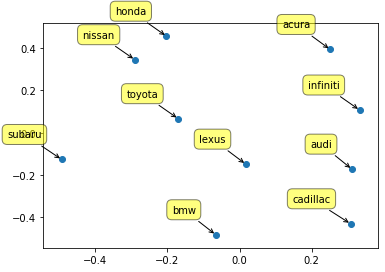

In [168]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(a_liftinv)
coords = results.embedding_
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(brands, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

From the MDS map, we observe the following:
1. Subaru seems to be further away from the other luxury cars, showing that there are lesser chances of users discussing about Subaru, when discussing others. In other words, Subaru is considered more dissimilar to the other luxury cars.
2. Honda and nissan seems to be the closest in the MDS map and highest on lift at 3.75, showing that if we observe honda being mentioned in a user post, there is a higher probabilty of observing nissan as a co-mention, than nissan being mentioned otherwise. It is also interesting that these two brands seem to have the highest lift in the luxury car segment.
3. Since it is the luxury car segment, one would expect one of the highest associations between bmw and audi. However, we see that the lift value is comparitively lower for this pair at 1.89.
4. We also see that there is high association between toyota and lexus with a lift value of 3.07,showing that more conversations seemed to include co-mentions of toyota and lexus.

Find top attributes for the brands:

1. Find the top 5 most frequently mentioned attributes about a brand from wordcount dataframe. Remove brands and models from dataframe and then sort values in descending order to obtain the most commonly occurring attributes
2. After sorting through the non brand/non model list of words, utilize the top most frequently occurring attributes to create the attributes list
3. Identify which of these attributes are referred to in each post.
4. Compute the total attribute mentions across all posts and identify the top5_attributes based on frequency of occurrence.
3. Create top5_attribute_brand pairs between top5_brands and top5_attributes
4. Compute lift between these pairs across all user posts
  1. N: This is the total number of mentions of all brands and all attributes
  2. N_A: This is the total number of mentions of a brand 
  3. N_B: This is the total number of mentions of an attribute
  4. N_AB: This is the total number of co-mentions of brand and attribute

In [0]:
brands_list=list(models['brand'].unique())
models_list=list(models['model'].unique())
totalattributes_list=['performance','engine','power','luxury','price','suspension','transmission','torque','speed','acceleration','interior','quality','reliable','sport']

In [0]:

def getAttributes(word_list):
  user_post_non=[]
  for word in word_list:
    if (word  in totalattributes_list):
      user_post_non.append(word)
  return list(set(user_post_non))

In [0]:
comments['attribute']=comments['word_list'].map(getAttributes)

In [0]:
total_attribute=[]
for i in range(len(comments)):
  total_attribute=total_attribute+comments['attribute'][i]

In [0]:
pd.options.display.max_rows = 500
from collections import Counter
top_attributes=pd.DataFrame(sorted(Counter(total_attribute).items(), key=lambda x: x[1], reverse=True))
top_attributes.rename(columns={0:'attribute',1:'frequency'},inplace=True)


In [0]:
#attribute_list=['performance','engine','price','speed','interior','luxury','power']
top5_attributes=top_attributes[top_attributes['attribute'].isin(totalattributes_list)][0:5]
top5_attributes_list=list(top5_attributes['attribute'])

In [175]:
top5_attributes

,attribute,frequency
0,performance,687
1,luxury,478
2,engine,443
3,price,437
4,power,387


From our analysis, we observe that below are the top 5 attributes most commonly mentioned:
1. Performance
2. Luxury
3. Engine
4. Price
5. Power

In [0]:
top5_brands=top_brands[0:5]
top5_brands_list=list(top5_brands['brand'])

In [0]:
def computeLift(brandA,attributeB):
  Lift_AB=0
  N_AB=0
  N=len(comments)
  N_A=top5_brands[top5_brands['brand']==brandA]['frequency'].values
  N_B=top5_attributes[top5_attributes['attribute']==attributeB]['frequency'].values
  for i in range(len(comments)):
    if((brandA in comments.iloc[i]['brands'])&(attributeB in comments.iloc[i]['attribute'])):
      N_AB+=1
  Lift_AB=(N*N_AB)/(N_A*N_B)
  return(Lift_AB)


In [0]:
top5_brands_total=[]
top5_brands_total.extend(top5_brands_list*5)

In [0]:
top5_brands_total=sorted(top5_brands_total)

In [0]:
top5_attributes_tot=[]
top5_attributes_tot.extend(top5_attributes_list*5)

In [0]:
brand_attribute_pairs=list(zip(sorted(top5_brands_total), top5_attributes_tot))  

In [0]:
brand_att_Lift=[]
for i in range(len(brand_attribute_pairs)):
  brand_att_Lift.append((brand_attribute_pairs[i],computeLift(brand_attribute_pairs[i][0],brand_attribute_pairs[i][1])[0]))

In [183]:
brand_att_table=pd.DataFrame(brand_att_Lift)
brand_att_table.rename(columns={0:'brand_attribute_pairs',1:'lift'},inplace=True)
brand_att_table.sort_values(by='lift',ascending=False)

,brand_attribute_pairs,lift
8,"(audi, price)",2.200317
21,"(toyota, luxury)",2.133445
23,"(toyota, price)",2.054969
22,"(toyota, engine)",1.803808
9,"(audi, power)",1.795321
7,"(audi, engine)",1.764419
20,"(toyota, performance)",1.728114
18,"(infiniti, price)",1.701973
24,"(toyota, power)",1.651859
19,"(infiniti, power)",1.636686


From the above table, we can see that below are the strongest associations for each brand to an attribute:
1. Audi & Price
2. Toyota & Luxury
3. Infiniti & Price
4. BMW & Power
5. Acura & Price

Interestingly, we see that Toyota and luxury have a higher lift value or association than other luxury brands. It should also be noted that users typically associate Audi with price. (this could mean a positive or negative sentiment; users could be referring to the high price). Given BMW's tagline of 'The Ultimate Driving Machine', we can see reasoning for BMW having the highest association with power.

From tha above analysis, below would be a few recommendations (assuming user sentiments are positive towards the attributes):
1. Toyota is typically not known as a luxury brand. However, it can be seen that users associate Toyota in the luxury car segment, more than the others. For that reason, an advertising/marketing manager might want to consider channelling this to their brand communication.
2. Given BMW's tagline of 'The Ultimate Driving Machine' and the high association between BMW and power, it looks like the users are resounding with the brand's value.
3. Interestingly, brands like audi and bmw, which are perceived as luxury cars, do not seem to show the highest association with luxury. This might be something to consider in terms of how to advertise/market these attributes of the brand better.
4. With audi, acura and infiniti, the primary association with an attribute seems to be price. Since customer's have a positive sentiment towards price with respect to these brands, including price parameters in their communication could add additional value.

In [0]:
brands_attributes_table=pd.DataFrame(brand_att_table['brand_attribute_pairs'].values.tolist(), index=brand_att_table.index)
brands_attributes_table['lift']=brand_att_table['lift']
brands_attributes_table.rename(columns={0:'brandA',1:'attributeB'},inplace=True)

In [185]:
brands_attributes_table

,brandA,attributeB,lift
0,acura,performance,1.377077
1,acura,luxury,1.537551
2,acura,engine,1.297218
3,acura,price,1.601294
4,acura,power,1.525336
5,audi,performance,1.616335
6,audi,luxury,1.505446
7,audi,engine,1.764419
8,audi,price,2.200317
9,audi,power,1.795321


In [186]:
brands_attributes_table[brands_attributes_table['attributeB']=='performance'].sort_values(by='lift',ascending=False)

,brandA,attributeB,lift
20,toyota,performance,1.728114
5,audi,performance,1.616335
10,bmw,performance,1.531168
15,infiniti,performance,1.480749
0,acura,performance,1.377077


In [187]:
brands_attributes_table[brands_attributes_table['attributeB']=='luxury'].sort_values(by='lift',ascending=False)

,brandA,attributeB,lift
21,toyota,luxury,2.133445
1,acura,luxury,1.537551
6,audi,luxury,1.505446
11,bmw,luxury,1.400416
16,infiniti,luxury,1.375292


In [188]:
brands_attributes_table[brands_attributes_table['attributeB']=='price'].sort_values(by='lift',ascending=False)

,brandA,attributeB,lift
8,audi,price,2.200317
23,toyota,price,2.054969
18,infiniti,price,1.701973
13,bmw,price,1.609959
3,acura,price,1.601294


In [189]:
brands_attributes_table[brands_attributes_table['attributeB']=='engine'].sort_values(by='lift',ascending=False)

,brandA,attributeB,lift
22,toyota,engine,1.803808
7,audi,engine,1.764419
12,bmw,engine,1.549606
17,infiniti,engine,1.462286
2,acura,engine,1.297218


In [190]:
brands_attributes_table[brands_attributes_table['attributeB']=='power'].sort_values(by='lift',ascending=False)

,brandA,attributeB,lift
9,audi,power,1.795321
24,toyota,power,1.651859
19,infiniti,power,1.636686
14,bmw,power,1.632637
4,acura,power,1.525336


In [191]:
brands_attributes_table.groupby('brandA')['lift'].agg(sum)

brandA
acura       7.338475
audi        8.881837
bmw         7.723786
infiniti    7.656985
toyota      9.372195
Name: lift, dtype: float64

An aspirational brand would be that which has the highest association with the attributes which are most frequently talked about. In this dataset, these attributes are performance, luxury, power, engine and price. The most aspirational brand would have the best combination of the top 5 attributes. 

We observe that Toyota has the highest combination of lift values across the top 5 attributes, thereby making it the most aspirational brand.

In [192]:
comments.head()

,Unnamed: 0,Date,user_id,comments,filtered comments,word_list,brands,attribute
0,0,"March 25, 2002 5:54AM",merc1,I personally think that with a few tweaks the ...,personally think tweaks mercedes could also si...,"[personally, think, tweaks, mercedes, could, a...","[audi, buick, cadillac, mercedes, acura, infin...","[luxury, power, price, speed, interior, transm..."
1,1,"March 25, 2002 7:06AM",fredvh,I am debating a new purchase and these two are...,debating new purchase two top list price diffe...,"[debating, new, purchase, two, top, list, pric...","[lexus, acura, honda]","[quality, price]"
2,2,"March 25, 2002 5:02PM",blueguydotcom,"Great handling, RWD, excellent engine and the ...",great handling rwd excellent engine best warra...,"[great, handling, rwd, excellent, engine, best...",[],[engine]
3,3,"March 25, 2002 11:04PM",hungrywhale,And no manual tranny. That may not matter to y...,manual tranny may matter certainly matter many...,"[manual, tranny, may, matter, certainly, many,...",[],[]
4,4,"March 26, 2002 12:44AM",riez,One beauty of BMW 3 Series is that there are s...,one beauty bmw 3 series many models choose alm...,"[one, beauty, bmw, 3, series, many, models, ch...",[bmw],"[engine, transmission, performance]"


In [0]:
comments.to_csv('updated_datafile.csv')